In [ ]:
#Import libraries
import pytz
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_ta as ta
import MetaTrader5 as mt5
from datetime import datetime, timedelta, time
from tensorflow.keras.models import save_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Initialize connection to the MetaTrader 5 terminal
if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login=51863590, server="ICMarketsSC-Demo", password="1lfz&CJ7jyX2N8")
    timezone = pytz.timezone("America/Bogota")
    symbol = "XAUUSD"
    now = datetime.now(tz=timezone)
    # Retrieve monthly, weekly, and daily data
    #This data will be used for predictions:
    data15 = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M15, datetime(2016, 1, 1), now)
    data5 = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M5, datetime(2022, 1, 1), now)
    data1 = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2023, 8, 1), now)
    # Create DataFrames
    df_15 = pd.DataFrame(data15)
    df_5 = pd.DataFrame(data5)
    df_1 = pd.DataFrame(data1)
    #Truncate the data
    lenght = len(df_15)
    df_5 = df_5.tail(lenght)
    # Calculate RSI and EMA Necessary Indicators to improve our model
    df_15['rsi'] = ta.rsi(df_15['close'], length=8)
    df_15['ema'] = ta.ema(df_15['close'], length=22)
    df_5['rsi'] = ta.rsi(df_5['close'], length=8)
    df_5['ema'] = ta.ema(df_5['close'], length=22)
    df_1['rsi'] = ta.rsi(df_1['close'], length=8)
    df_1['ema'] = ta.ema(df_1['close'], length=22)
    # Fill NaN values
    df_15['rsi'].fillna(df_15['rsi'].mean(), inplace=True)
    df_15['ema'].fillna(df_15['ema'].mean(), inplace=True)
    df_5['rsi'].fillna(df_5['rsi'].mean(), inplace=True)
    df_5['ema'].fillna(df_5['ema'].mean(), inplace=True)
    df_1['rsi'].fillna(df_1['rsi'].mean(), inplace=True)
    df_1['ema'].fillna(df_1['ema'].mean(), inplace=True)
    # Concatenate vertically
    df = pd.concat([df_15, df_5, df_1], ignore_index=True)
    columns_to_drop = ['spread', 'time', 'real_volume']
    df.drop(columns=columns_to_drop, inplace=True)
else:
    print("Failed to initialize MetaTrader 5.")

In [3]:
#Create a test set
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(df.values.reshape((-1, 1)))
#Scale the test data
def create_dataset(dataset, N=120):
    X, Y = [], []
    for i in range(len(dataset) - N):
        X.append(dataset[i:(i + N), 0])
        Y.append(dataset[i + N, -1])
    return np.array(X), np.array(Y)
# Apply the new function
N = 120
X_train, y_train = create_dataset(train_scaled, N)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(-1, 1) #np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #y_train.reshape(-1, 1)
print("Train shapes for X and y respectivelly", X_train.shape, y_train.shape)
print("Train sizes for X and y respectivelly", X_train.size, y_train.size)
print('Full time Lenght', len(df))

Train shapes for X and y respectivelly (5288835, 120, 1) (5288835, 1)
Train sizes for X and y respectivelly 634660200 5288835
Full time Lenght 755565


In [4]:
model = keras.models.load_model(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\.vscode\Model09.keras")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 120, 30)           3840      
                                                                 
 dropout_18 (Dropout)        (None, 120, 30)           0         
                                                                 
 lstm_20 (LSTM)              (None, 120, 25)           5600      
                                                                 
 dropout_19 (Dropout)        (None, 120, 25)           0         
                                                                 
 dense_5 (Dense)             (None, 120, 1)            26        
                                                                 
Total params: 9,466
Trainable params: 9,466
Non-trainable params: 0
_________________________________________________________________


20/20 [==============================] - 0s 14ms/step
Test shapes for X and y respectivelly (610, 120, 1) (610, 120, 1)
Test sizes for X and y respectivelly 73200 73200


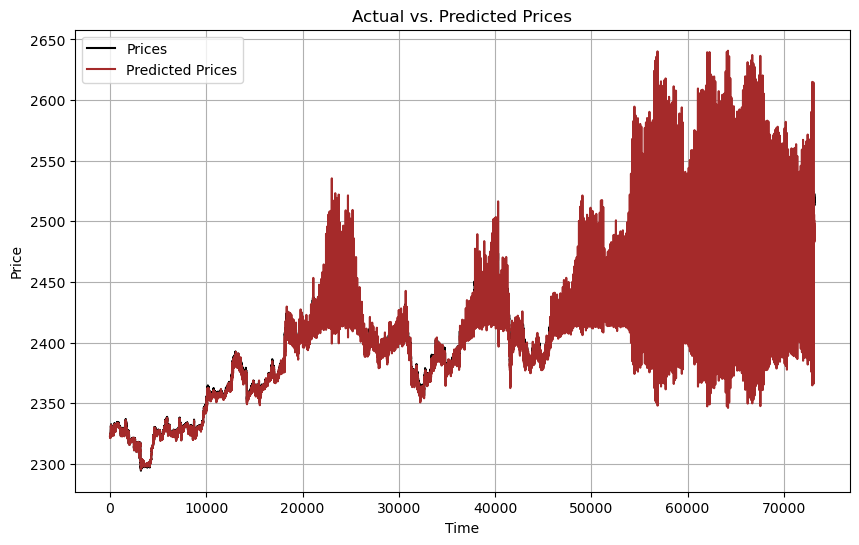

In [11]:
#CREATE A THE TEST DF
test = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2024, 6, 1), now)
test = pd.DataFrame(test)
test = test['close'].tail(73368)
test_scaled = scaler.fit_transform(np.array(test).reshape(-1, 1))
_, X_test = create_dataset(test_scaled, N)
_, y_test = create_dataset(test_scaled, N)
#RESHAPE FOR PREDICTIONS
elements_two = X_test.size
divisible_two = (elements_two // 120) * 120
X_predict_shape = X_test[:divisible_two]
X_test = X_predict_shape.reshape(-1, 120, 1)
#RESHAPE FOR PREDICTIONS
elements_one = y_test.size
divisible_one = (elements_one // 120) * 120
y_predict_shape = y_test[:divisible_one]
y_test = y_predict_shape.reshape(-1, 120, 1)

y_pred = model.predict(X_test)
# Inverse scaling
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Test shapes for X and y respectivelly", X_test.shape, y_test.shape)
print("Test sizes for X and y respectivelly", X_test.size, y_test.size)
# Plot the results
now = datetime.now()
sixty_days = now + timedelta(days=60)
sixty_days = sixty_days.replace(microsecond=0)
date_range = pd.date_range(start=now.replace(microsecond=0), end=sixty_days, freq='1min')
date_range = date_range[date_range.dayofweek < 5]
time_df = pd.DataFrame(date_range)
rows = len(time_df)
mt5.shutdown()
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Prices', color='black')
plt.plot(y_pred, label='Predicted Prices', color='brown')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.grid(True)
plt.legend()
plt.show()

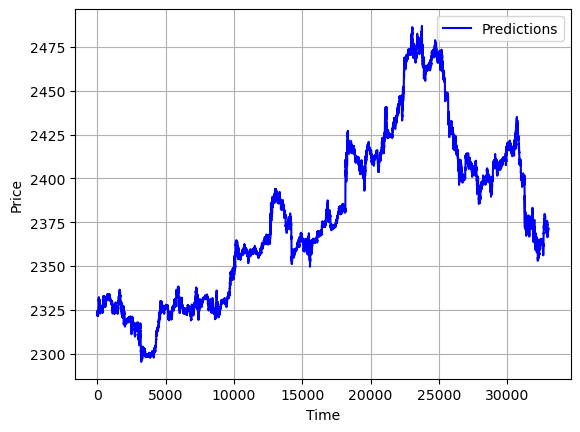

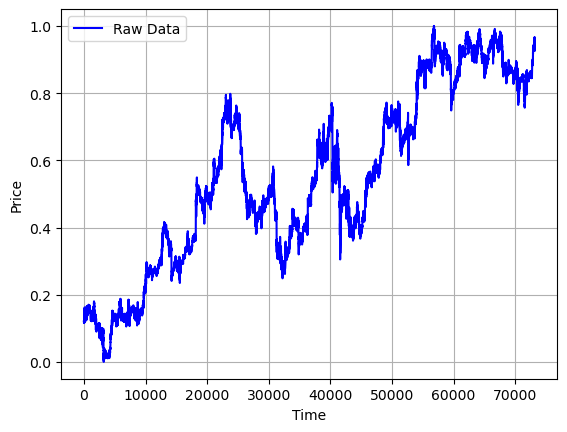

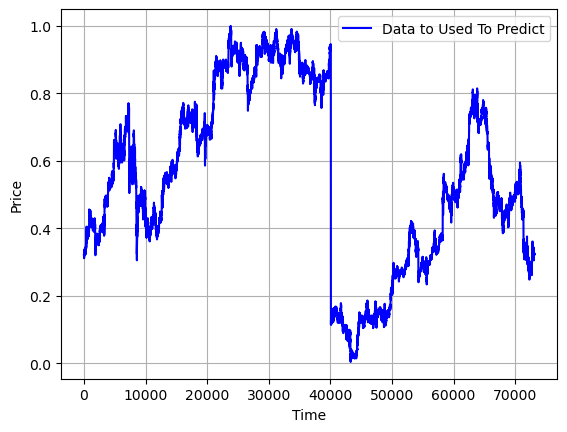

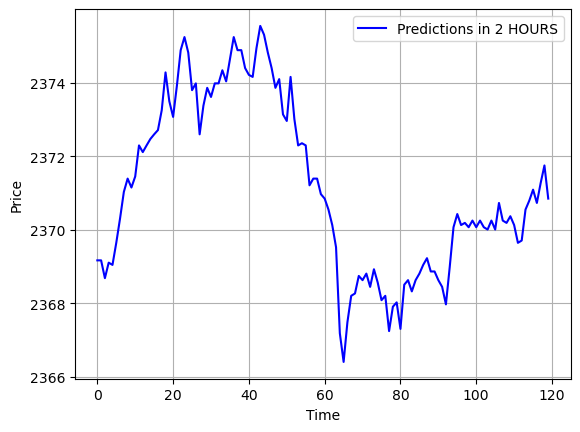

Preictions with the model of 15k parameters


In [12]:
# Initialize predictions list
import math
batch_size = 60
M = 33000
R = 960  #  840=7500,  
timestamps = 1 #R // 60
predictions = []
window_data = X_test[-R:] #600 10
for i in range(M):
    prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
    predictions.append(prediction[0, 0])  
    window_data = np.roll(window_data, -timestamps)  # Shift data by one time step
    window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
    if len(prediction) > M:
        break
q = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# To show the real values   real = scaler.inverse_transform(np.array(window_data).reshape(-1, 1))
if np.isnan(predictions).sum() == 0:
    plt.plot(predictions, color='blue', label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Predictions contain NaN values.")
if np.isnan(X_test[-R:].reshape(-1, 1)).sum() == 0:
    plt.plot(X_test[-R:].reshape(-1, 1), color='blue', label='Raw Data')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
if np.isnan(window_data.reshape(-1, 1)).sum() == 0:
    plt.plot(window_data.reshape(-1, 1), color='blue', label='Data to Used To Predict')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
if np.isnan(predictions[-120:]).sum() == 0:
    plt.plot(predictions[-120:], color='blue', label='Predictions in 2 HOURS')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
print('Preictions with the model of 15k parameters')

In [13]:
#SAVE THE DATAFRAMES
stock_prices_df = pd.DataFrame(predictions)
minutes_predicted = len(predictions)
#Create a new full dataframe to be used in our trading bot.
full_df = pd.concat([time_df, stock_prices_df], axis='columns')
full_df = full_df.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
full_df = full_df[:minutes_predicted]
full_df.columns = ['Date', 'Price']
full_df['Price'] = full_df['Price'].astype(float).round(8)

#Save the dataframe
full_df.to_csv("XAUUSD-Df.csv", index=False)
print(full_df.duplicated)

<bound method DataFrame.duplicated of                      Date        Price
index                                 
0     2024-09-05 12:11:08  2322.784912
1     2024-09-05 12:12:08  2322.941162
2     2024-09-05 12:13:08  2322.842041
3     2024-09-05 12:14:08  2323.168457
4     2024-09-05 12:15:08  2323.210938
...                   ...          ...
32995 2024-10-08 10:06:08  2371.093018
32996 2024-10-08 10:07:08  2370.732178
32997 2024-10-08 10:08:08  2371.271973
32998 2024-10-08 10:09:08  2371.750732
32999 2024-10-08 10:10:08  2370.850098

[33000 rows x 2 columns]>
